In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from harang import utils, vision
import cv2
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import gc

<IPython.core.display.Javascript object>

W1119 08:36:36.929536  2492 deprecation_wrapper.py:119] From ..\harang\vision.py:22: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1119 08:36:36.932536  2492 deprecation_wrapper.py:119] From ..\harang\vision.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1119 08:36:37.774727  2492 deprecation_wrapper.py:119] From ..\harang\vision.py:25: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.



In [2]:
stage = 'stage2'

In [3]:
def ensemble(paths, test=False, mode='cls'):
    res = None
    for path in paths:
        if test:
            path = f'{stage}/test_preds/{mode}/{path}'
        else:
            path = f'{stage}/oof_preds/{mode}/{path}'
        if res is None:
            res = utils.from_pickle(path)/len(paths)
        else:
            res += utils.from_pickle(path)/len(paths)
    return res

# Classification

In [4]:
paths = [
    'efficientnetb2_0.8704.pkl',
    'efficientnetb3_0.8689.pkl',
]

In [5]:
def pr_auc(true, pred):
    pr_auc_mean = 0
    for class_i in range(4):
        precision, recall, _ = precision_recall_curve(true[:, class_i], pred[:, class_i])
        pr_auc = auc(recall, precision)
        pr_auc_mean += pr_auc/4
    return pr_auc_mean

In [6]:
oof_pred = ensemble(paths, test=False, mode='cls')
oof_true = utils.from_pickle('data/y_data.pkl').sum(axis=(1,2))!=0
test_pred = ensemble(paths, test=True, mode='cls')

In [7]:
score = pr_auc(oof_true, oof_pred)
score_str = str(score)[:6]
print(score)

0.8714844759859993


In [8]:
utils.to_pickle(f'{stage}/oof_preds/cls/ensemble_{score_str}.pkl', oof_pred)
utils.to_pickle(f'{stage}/test_preds/cls/ensemble_{score_str}.pkl', test_pred)

# Segmentation

In [6]:
paths = [
    'unet_efficientnetb2_0.6492.pkl',
    'unet_efficientnetb3_0.6514.pkl',
    'efficientnetb2_0.6482.pkl'
]
cls_path = 'ensemble_0.8714.pkl'

In [7]:
def single_dice_metric(y_true, y_pred_bin):
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))

def dice_metric(y_true, y_pred_bin):
    batch_size = y_true.shape[0]
    channel_num = y_true.shape[-1]
    mean_dice_metric = 0.
    for i in range(batch_size):
        for j in range(channel_num):
            mean_dice_metric += single_dice_metric(y_true[i, :, :, j], y_pred_bin[i, :, :, j]) / (channel_num*batch_size)
    return mean_dice_metric

In [8]:
def draw_convex_hull(mask, mode='convex'):
    
    img = np.zeros(mask.shape)
    contours, hier = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        if mode=='rect': # simple rectangle
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 255), -1)
        elif mode=='convex': # minimum convex hull
            hull = cv2.convexHull(c)
            cv2.drawContours(img, [hull], 0, (255, 255, 255),-1)
        elif mode=='approx':
            epsilon = 0.02*cv2.arcLength(c,True)
            approx = cv2.approxPolyDP(c,epsilon,True)
            cv2.drawContours(img, [approx], 0, (255, 255, 255),-1)
        else: # minimum area rectangle
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(img, [box], 0, (255, 255, 255),-1)
            
    return (img/255.).astype(np.uint8)

def fill_mask(pred, pred_bin, cls_pred, thresh, step):
    fix_indices = np.where(pred_bin.sum(axis=(1,2,3))==0)[0]
    if len(fix_indices) == 0:
        return pred_bin
    new_thresh = thresh-step
    fix_channels = cls_pred[fix_indices].argmax(axis=1)
    for i,c in zip(fix_indices, fix_channels):
        pred_bin[i,:,:,c] = (pred[i,:,:,c]>new_thresh).astype(np.uint8)
    pred_bin[fix_indices] = (pred[fix_indices]>new_thresh).astype(np.uint8)
    return fill_mask(pred, pred_bin, cls_pred, new_thresh, step)

def postprocess(y_pred, cls_pred=None, min_cls=0.6, min_prob=0.5, min_size=0.05, fill_step=None, convex=True):
    if cls_pred is not None:
        min_cls_pass = (cls_pred>min_cls).reshape(-1, 1, 1, 4)
        y_pred = y_pred * min_cls_pass
    mask = (y_pred>min_prob).astype(np.uint8)
    res = np.zeros(mask.shape, dtype=np.uint8)
    if min_size:
        for i in range(len(mask)):
            for j in range(4):
                tmp = mask[i, :, :, j].copy()
                num_component, component = cv2.connectedComponents(tmp.astype(np.uint8))
                for c in range(1, num_component):
                    p = (component == c)
                    if p.sum() < min_size*tmp.shape[0]*tmp.shape[1]:
                        tmp[p] = 0
                res[i, :, :, j] = tmp
        mask = res
    if fill_step:
        mask = fill_mask(y_pred, mask, cls_pred, min_prob, fill_step)
    if convex:
        res = np.zeros(mask.shape, dtype=np.uint8)
        for i in range(len(mask)):
            for j in range(4):
                tmp = mask[i, :, :, j]
                res[i, :, :, j] = draw_convex_hull(tmp)
        mask = res
    return mask

In [7]:
oof_pred = ensemble(paths, test=False, mode='seg')
oof_true = utils.from_pickle('data/y_data.pkl')
cls_oof = utils.from_pickle(f'{stage}/oof_preds/cls/{cls_path}')

raw_score = dice_metric(oof_true, oof_pred>0.5)
raw_score_str = str(raw_score)[:6]
post_score = dice_metric(oof_true, postprocess(oof_pred, cls_oof))
post_score_str = str(post_score)[:6]
print(raw_score, post_score)

0.6513018523881846 0.6551144667454726


In [8]:
utils.to_pickle(f'{stage}/oof_preds/seg/ensemble_{raw_score_str}_{post_score_str}.pkl', oof_pred)

NameError: name 'test_pred' is not defined

# Submission

In [4]:
raw_score_str = 0.6513
post_score_str = 0.6551

In [9]:
test_pred = ensemble(paths, test=True, mode='seg')
cls_test = utils.from_pickle(f'{stage}/test_preds/cls/{cls_path}')

In [10]:
utils.to_pickle(f'{stage}/test_preds/seg/ensemble_{raw_score_str}_{post_score_str}.pkl', test_pred)

In [11]:
test_pred_bin = postprocess(test_pred, cls_pred=cls_test)
sub = pd.read_csv('data/sample_submission.csv')
index = 0
for i in range(len(test_pred_bin)):
    cur = test_pred_bin[i, :, :, :]
    rles = vision.build_rles(cur, reshape=(350, 525))
    for rle in rles:
        sub.loc[index, 'EncodedPixels'] = rle
        index += 1
sub.to_csv(f'submissions/{post_score_str}.csv', index=False)

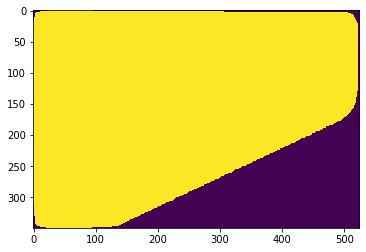

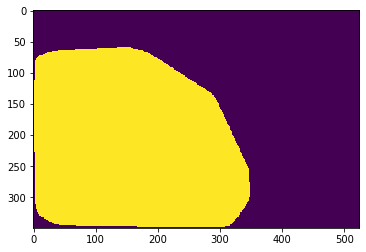

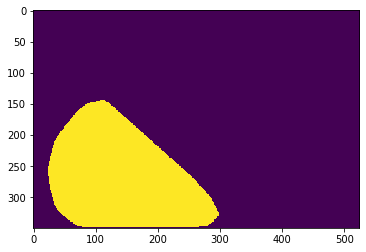

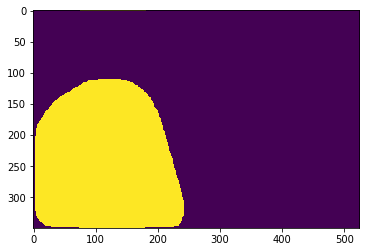

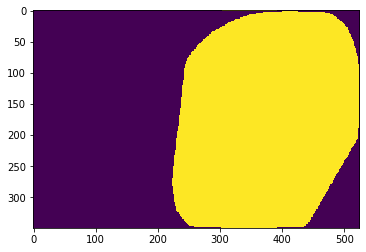

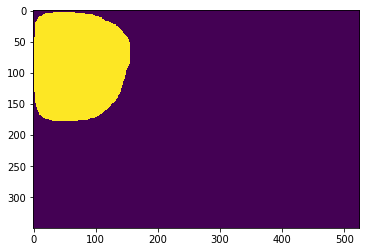

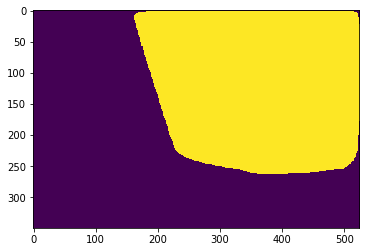

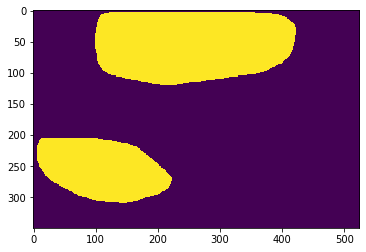

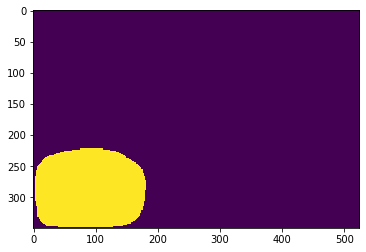

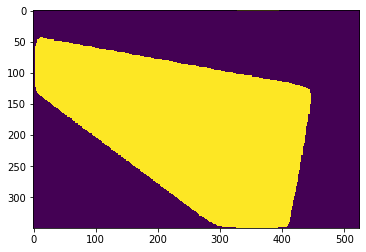

In [12]:
tmp = sub[sub['EncodedPixels'].astype(bool)]
for i in tmp.index[:10]:
    plt.imshow(vision.rle2mask(tmp.loc[i, 'EncodedPixels'], input_shape=(350, 525)))
    plt.show()